In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

t = time.time()

Nous étudions dans ce notebook le modèle de **regression logistique**.

# 1. Chargement d'une base Sentiment140 préprocessée 

On travaille tout d'abord à pré-processing fixé.

In [2]:
def sentiment140(stop_words, lemmatization, negation, nb_data):
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(nb_data, random_state=1234)

In [3]:
NB_DATA = 200000
STOP_WORDS = True
LEMMATIZATION = True
NEGATION = False
df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)

In [4]:
df.head(10)

,sentiment,id,date,query_string,user,text
443760,Negative,2067643150,Sun Jun 07 12:42:21 PDT 2009,NO_QUERY,alwaysasidekick,yeah everyone leave
1177982,Positive,1981504351,Sun May 31 09:17:33 PDT 2009,NO_QUERY,misakouroco,beautiful day love love love washington state ...
1163662,Positive,1979696545,Sun May 31 04:08:08 PDT 2009,NO_QUERY,julfree461,look foward first day back work watch ufc tonight
933642,Positive,1792004569,Wed May 13 21:48:36 PDT 2009,NO_QUERY,laura_wtcc,go bed night
1538716,Positive,2179949435,Mon Jun 15 09:48:19 PDT 2009,NO_QUERY,lynnnein,flylady finish closet hot pull anything today ...
855941,Positive,1573666658,Tue Apr 21 02:15:45 PDT 2009,NO_QUERY,jessikasolomon,good work go breakfast balcony
275551,Negative,1990835470,Mon Jun 01 05:51:08 PDT 2009,NO_QUERY,tweetermestupid,homework sigh hate tredtri professor
850269,Positive,1565396135,Mon Apr 20 06:39:22 PDT 2009,NO_QUERY,roxipid,healthy eat remember
1022805,Positive,1882874195,Fri May 22 07:37:58 PDT 2009,NO_QUERY,FelipeAzucares,would even impressed book capable ascertain so...
289349,Negative,1994988374,Mon Jun 01 12:46:27 PDT 2009,NO_QUERY,amberama,take general donation ticket colts vs patriot ...


In [5]:
X = df.text.to_list()
y = df.sentiment.to_list()

Calculons le nombres de mots :

In [6]:
nb_max_words = len(CountVectorizer().fit(X).get_feature_names())
nb_max_words

70614

# 2. Différentes méthodes de feature extraction
## 2.1. Count Vectorizer
### 2.1.1. Exemple

In [7]:
array = ["Car was cleaned by Jack", 
         "Jack was cleaned by Car", 
         "Hello"]
vectorizer = CountVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

L'encodage de la table `array` par la méthode **Count Vectorizer** est : 

In [8]:
print(X_.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


### 2.1.2. Application de la regression logistique

In [45]:
class Modelisation():
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

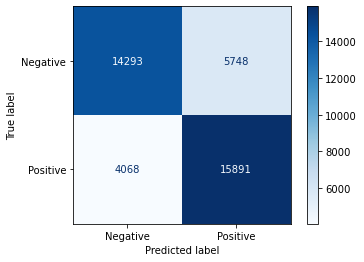

Accuracy : 0.7546
Balanced accuracy : 0.7564
ROC AUC : 0.8332
Wall time: 2.47 s


In [46]:
%%time
m = Modelisation(X, y, CountVectorizer(max_features=1000), LogisticRegression())
m.show_conf_matrix()

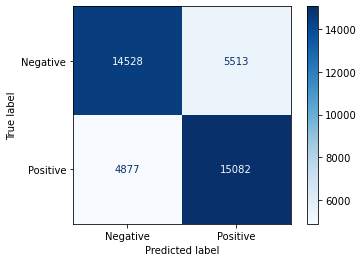

Accuracy : 0.7402
Balanced accuracy : 0.7405
ROC AUC : 0.7728
Wall time: 18 s


In [47]:
%%time
m = Modelisation(X, y, CountVectorizer(), LogisticRegression(max_iter=1000))
m.show_conf_matrix()

## 2.2. TF-IDF
### 2.2.1. Exemple

In [12]:
array = ["Blue car was cleaned by Jack", 
         "Jack was cleaned by red car", 
         "Hello"]
vectorizer = TfidfVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

L'encodage de la table `array` par la méthode **TD-IDF** est : 

In [13]:
print(X_.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


### 2.2.2. Application de la regression logistique

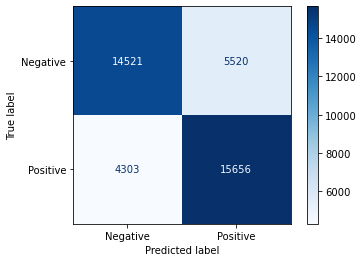

Accuracy : 0.7544
Balanced accuracy : 0.7554
ROC AUC : 0.8375
Wall time: 3.01 s


In [48]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=1000), LogisticRegression())
m.show_conf_matrix()

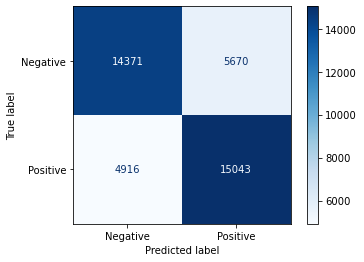

Accuracy : 0.7353
Balanced accuracy : 0.7357
ROC AUC : 0.7725
Wall time: 16.7 s


In [49]:
%%time
m = Modelisation(X, y, TfidfVectorizer(), LogisticRegression(max_iter=1000))
m.show_conf_matrix()

## 2.3. N-grams

La méthode N-grams peut-être utilisé sur les méthodes **Count Vectorizer** et **TD-IDF**. Elle permet de considérer des couples de mots et donc un environnement plus large.

Le paramètre `negation` du multiprocessing correspond à un exemple de N-grams.

### 2.3.1. Exemple

In [16]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue',
 'blue car',
 'by',
 'by jack',
 'by red',
 'car',
 'car was',
 'cleaned',
 'cleaned by',
 'hello',
 'jack',
 'jack was',
 'red',
 'red car',
 'was',
 'was cleaned']

L'encodage de la table `array` par les méthodes **Count Vectorizer et N-grams** est : 

In [17]:
print(X_.toarray())

[[1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1]
 [0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [18]:
nb_max_ngrams = len(CountVectorizer(ngram_range=(1, 2)).fit(X).get_feature_names())
nb_max_ngrams

729748

### 2.3.2. Application de la regression logistique

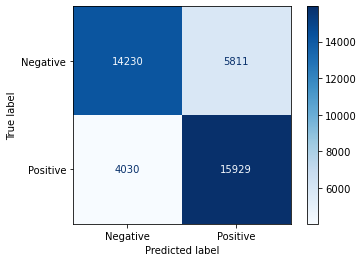

Accuracy : 0.7540
Balanced accuracy : 0.7560
ROC AUC : 0.8324
Wall time: 7.25 s


In [50]:
%%time
m = Modelisation(X, y, CountVectorizer(max_features=1000, ngram_range=(1, 2)), LogisticRegression(max_iter=200))
m.show_conf_matrix()

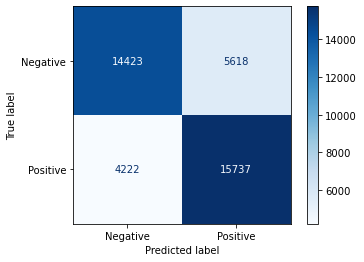

Accuracy : 0.7540
Balanced accuracy : 0.7552
ROC AUC : 0.8364
Wall time: 7.26 s


In [51]:
%%time
m = Modelisation(X, y, TfidfVectorizer(max_features=1000, ngram_range=(1, 2)), LogisticRegression(max_iter=200))
m.show_conf_matrix()

# 3. Comparaisons des méthodes de feature extraction

L'objectif est de comparer les 3 méthodes de feature extraction **Count Vectorizer**, **TD-IDF** et **N-grams**, en faisant ensuite varier la méthode de pré-processing et le nombre de features.
Nous pourrons alors en déduire la combinaison optimale pour la **regression logistique**.

## 3.1. Comparaison des méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé

On compare les méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé pour l'instant.

In [21]:
def comparaison(X, y, N, show_graph=True):
    """
    N correspond au nombre de features
    """
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200))
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"CountVectorizer {N}")
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200))
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"TfidfVectorizer {N}")
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), LogisticRegression(max_iter=200))
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"CountVectorizer {N} ngram 2")
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), LogisticRegression(max_iter=200))
    fpr, tpr, _ = metrics.roc_curve(m.y_test, m.probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, label=f"TfidfVectorizer {N} ngram 2")
    table.append(m.metrics_score)
    
    if show_graph:
        plt.plot([0, 1], [0, 1], "r-")
        plt.plot([0, 0, 1], [0, 1, 1], 'b-')
        plt.legend()
        plt.show()
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

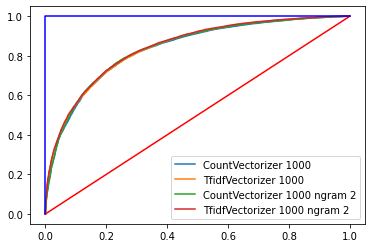

Wall time: 16.7 s


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.760650,0.761790,0.835289
TfidfVectorizer 1000,0.760200,0.760826,0.840073
CountVectorizer 1000 ngram 2,0.763175,0.764593,0.839320
TfidfVectorizer 1000 ngram 2,0.763250,0.763901,0.843614


In [22]:
%%time
comparaison(X, y, 1000)

**Conclusion :** Les modèle de feature extraction ont les mêmes performances (pour la méthode de pré-processing fixée et le nombre de features fixé).
L'apport de ngram semble donc être nul (seul les groupes de mots contenant un seul mot sont utiles).

## 3.2. Influence des méthodes de pré-processing
Nous faisons à présent varier les méthodes de pré-processing :

In [23]:
%%time
tables = []
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
            X = df_temp.text.to_list()
            y = df_temp.sentiment.to_list()            
            df_metrics = comparaison(X, y, 1000, show_graph=False)
            display(df_metrics)
            df_metrics['stop_words'] = stop_words
            df_metrics['lemmatization'] = lemmatization
            df_metrics['negation'] = negation
            tables.append(df_metrics)
df_metrics = pd.concat(tables)

stop_words: False, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.765325,0.766135,0.837963
TfidfVectorizer 1000,0.765325,0.765497,0.844891
CountVectorizer 1000 ngram 2,0.758625,0.759442,0.835099
TfidfVectorizer 1000 ngram 2,0.759400,0.759556,0.841572


stop_words: False, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.759550,0.760437,0.836120
TfidfVectorizer 1000,0.760500,0.760734,0.842746
CountVectorizer 1000 ngram 2,0.753375,0.753991,0.830489
TfidfVectorizer 1000 ngram 2,0.754075,0.754234,0.836038


stop_words: False, lemmatization: True, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.766250,0.766920,0.839607
TfidfVectorizer 1000,0.767575,0.767713,0.846695
CountVectorizer 1000 ngram 2,0.762275,0.763094,0.837632
TfidfVectorizer 1000 ngram 2,0.764100,0.764249,0.844243


stop_words: False, lemmatization: True, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.763875,0.764831,0.839554
TfidfVectorizer 1000,0.764775,0.765059,0.846524
CountVectorizer 1000 ngram 2,0.755875,0.756702,0.833174
TfidfVectorizer 1000 ngram 2,0.757200,0.757386,0.839047


stop_words: True, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.757750,0.759093,0.832602
TfidfVectorizer 1000,0.757700,0.758448,0.837206
CountVectorizer 1000 ngram 2,0.757025,0.758687,0.835099
TfidfVectorizer 1000 ngram 2,0.757275,0.758095,0.839001


stop_words: True, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.748975,0.751111,0.828685
TfidfVectorizer 1000,0.749475,0.750628,0.833069
CountVectorizer 1000 ngram 2,0.747550,0.749895,0.827636
TfidfVectorizer 1000 ngram 2,0.748700,0.749977,0.831717


stop_words: True, lemmatization: True, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.760650,0.761790,0.835289
TfidfVectorizer 1000,0.760200,0.760826,0.840073
CountVectorizer 1000 ngram 2,0.763175,0.764593,0.839320
TfidfVectorizer 1000 ngram 2,0.763250,0.763901,0.843614


stop_words: True, lemmatization: True, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 1000,0.754600,0.756406,0.833154
TfidfVectorizer 1000,0.754425,0.755368,0.837487
CountVectorizer 1000 ngram 2,0.753975,0.756002,0.832410
TfidfVectorizer 1000 ngram 2,0.754000,0.755241,0.836401


Wall time: 3min 35s


In [24]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 1000,0.767575,0.767713,0.846695,False,True,False
TfidfVectorizer 1000,0.764775,0.765059,0.846524,False,True,True
TfidfVectorizer 1000,0.765325,0.765497,0.844891,False,False,False
TfidfVectorizer 1000 ngram 2,0.764100,0.764249,0.844243,False,True,False
TfidfVectorizer 1000 ngram 2,0.763250,0.763901,0.843614,True,True,False
TfidfVectorizer 1000,0.760500,0.760734,0.842746,False,False,True
TfidfVectorizer 1000 ngram 2,0.759400,0.759556,0.841572,False,False,False
TfidfVectorizer 1000,0.760200,0.760826,0.840073,True,True,False
CountVectorizer 1000,0.766250,0.766920,0.839607,False,True,False
CountVectorizer 1000,0.763875,0.764831,0.839554,False,True,True


In [25]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 1000,0.767575,0.767713,0.846695,False,True,False
CountVectorizer 1000,0.766250,0.766920,0.839607,False,True,False
CountVectorizer 1000,0.765325,0.766135,0.837963,False,False,False
TfidfVectorizer 1000,0.765325,0.765497,0.844891,False,False,False
TfidfVectorizer 1000,0.764775,0.765059,0.846524,False,True,True
CountVectorizer 1000,0.763875,0.764831,0.839554,False,True,True
CountVectorizer 1000 ngram 2,0.763175,0.764593,0.839320,True,True,False
TfidfVectorizer 1000 ngram 2,0.764100,0.764249,0.844243,False,True,False
TfidfVectorizer 1000 ngram 2,0.763250,0.763901,0.843614,True,True,False
CountVectorizer 1000 ngram 2,0.762275,0.763094,0.837632,False,True,False


La combinaison optimale, pour le nombre de features fixé, correspond ici au pré-processing `stop_words: False, lemmatization: False, negation: False` combiné à la méthode de feature extraction **TF-IDF**. 

Toutes choses égales par ailleurs, la suppression des stop-words (`stop_words: True`) ne semble généralement pas bénéfique.

## 3.3. Influence du nombre de features
Nous faisons à présent varier le nombre de features.

### 3.3.1. Exemple avec une méthode de pré-processing fixé et TfidfVectorizer

array([ 199.5262315 ,  251.18864315,  316.22776602,  398.10717055,
        501.18723363,  630.95734448,  794.32823472, 1000.        ,
       1258.92541179, 1584.89319246, 1995.26231497, 2511.88643151,
       3162.27766017, 3981.07170553, 5011.87233627])

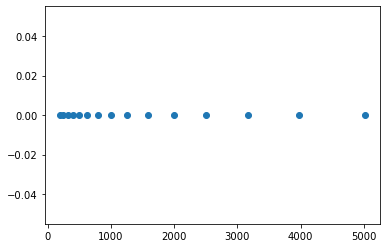

In [26]:
a = np.logspace(2.3, 3.7, 15, endpoint=True)
plt.plot(a, np.zeros(15), 'o')
a

Wall time: 1min 38s


[]

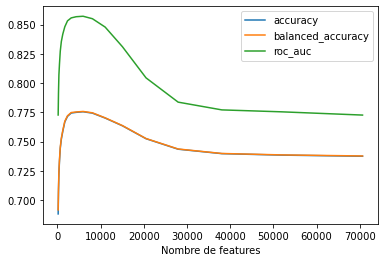

In [27]:
%%time
max_features_list = np.logspace(2.3, log(nb_max_words, 10), 20, endpoint=True, dtype=int)
table = []
for max_features in max_features_list:
    m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), LogisticRegression(max_iter=1000))
    table.append(m.metrics_score)
df_metrics = pd.DataFrame(table, index=max_features_list)

for i in df_metrics.columns:
    df_metrics[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()

Wall time: 3min 31s


[]

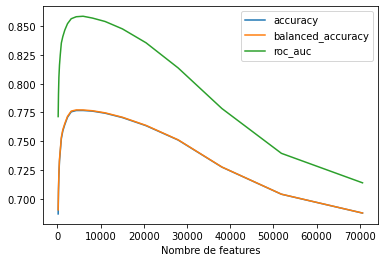

In [28]:
%%time
table = []
for max_features in max_features_list:
    m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), LogisticRegression(max_iter=1000))
    table.append(m.metrics_score)
df_metrics = pd.DataFrame(table, index=max_features_list)

for i in df_metrics.columns:
    df_metrics[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()

La méthode **N-gram** produit beaucoup plus de features (au maximum $n^2$ avec $n$ le nombre de mots). On peut donc regarder le graphique jusqu'au maximum du nombre de features avec la méthode **N-gram**.

Wall time: 14min 1s


[]

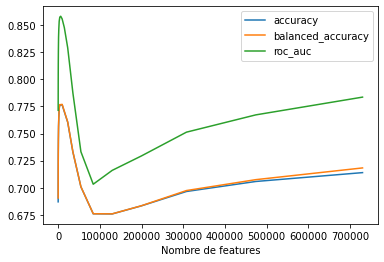

In [29]:
%%time
max_features_list_ngrams = np.logspace(2.3, log(nb_max_ngrams, 10), 20, endpoint=True, dtype=int)
table = []
for max_features in max_features_list_ngrams:
    m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), LogisticRegression(max_iter=5000))
    table.append(m.metrics_score)
df_metrics = pd.DataFrame(table, index=max_features_list_ngrams)

for i in df_metrics.columns:
    df_metrics[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()

Les performances ne sont pas meilleures, on se restreindra donc à des graphiques avec un nombre de features maximum correspondant au nombre de mots (ce qui correspond au maximum du nombre de features sans la méthode **N-gram**).

### 3.3.2 Pré-processing fixé et variation des méthodes de feature extraction

On garde le pré-processing fixé et on fait varier les méthodes de feature extraction.

In [30]:
def influence_features(X, y, max_features_list):
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), LogisticRegression(max_iter=2000))
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), LogisticRegression(max_iter=2000))
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1, 2)), LogisticRegression(max_iter=2000))
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), LogisticRegression(max_iter=2000))
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

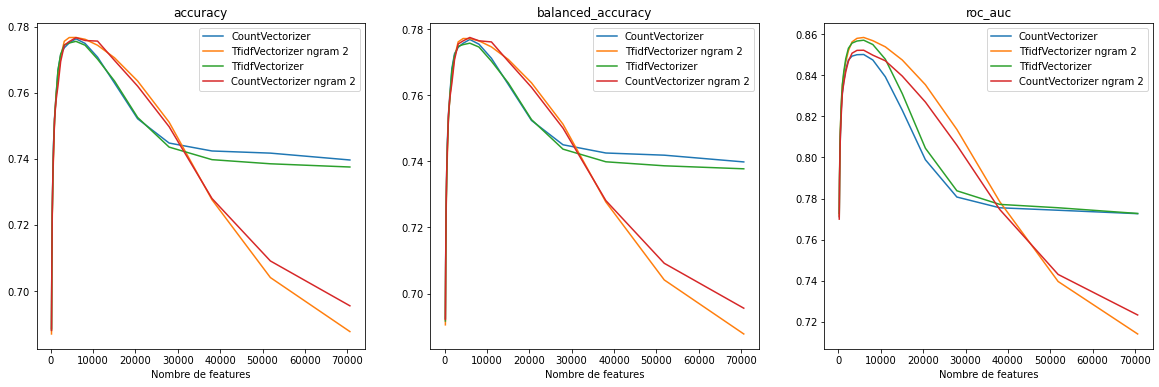

Wall time: 11min 5s


In [31]:
%%time
_ = influence_features(X, y, max_features_list)

### 3.3.3. Variations du pré-processing et des méthodes de feature extraction

Nous faisons à présent tout varier (pré-processing, feature extraction).

stop_words: False, lemmatization: False, negation: False


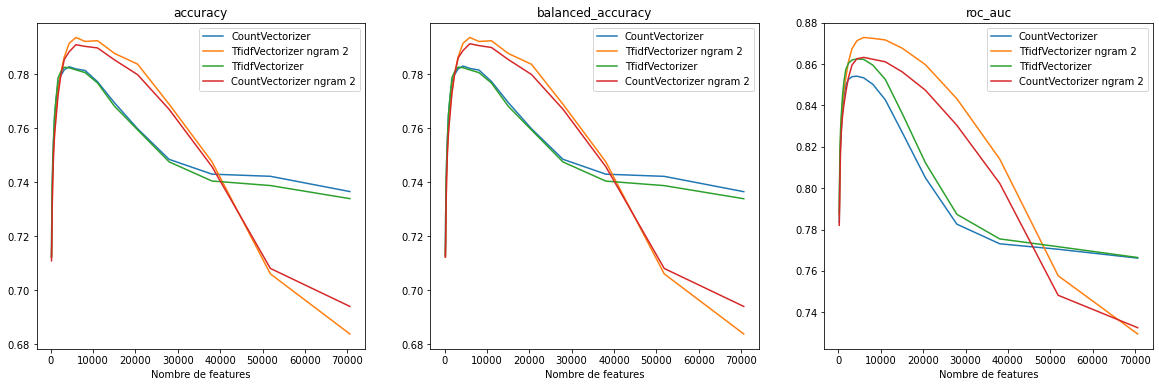

stop_words: False, lemmatization: False, negation: True


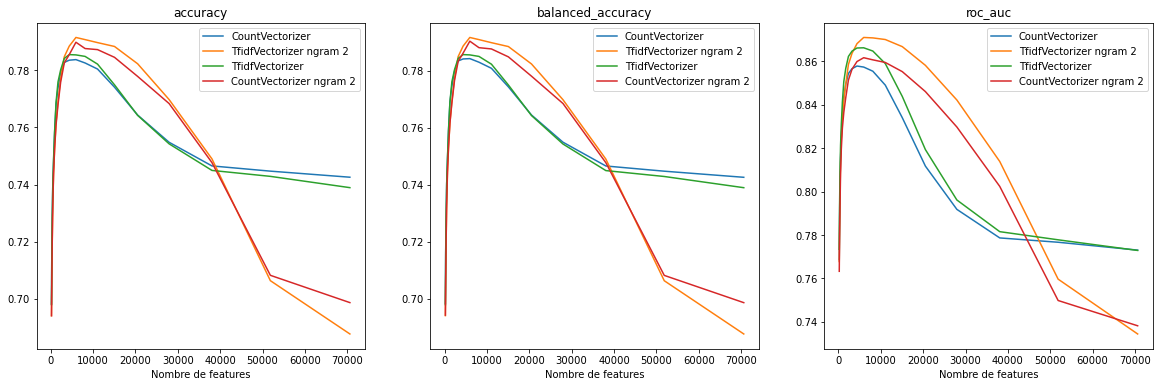

stop_words: False, lemmatization: True, negation: False


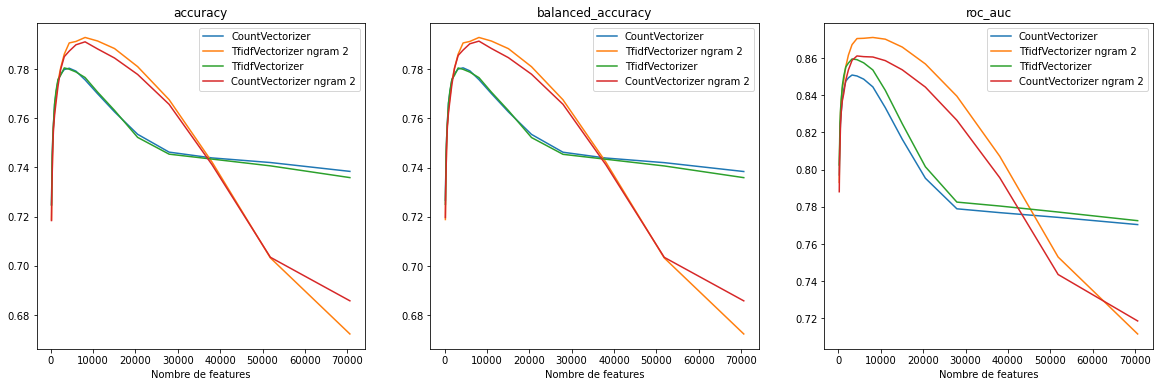

stop_words: False, lemmatization: True, negation: True


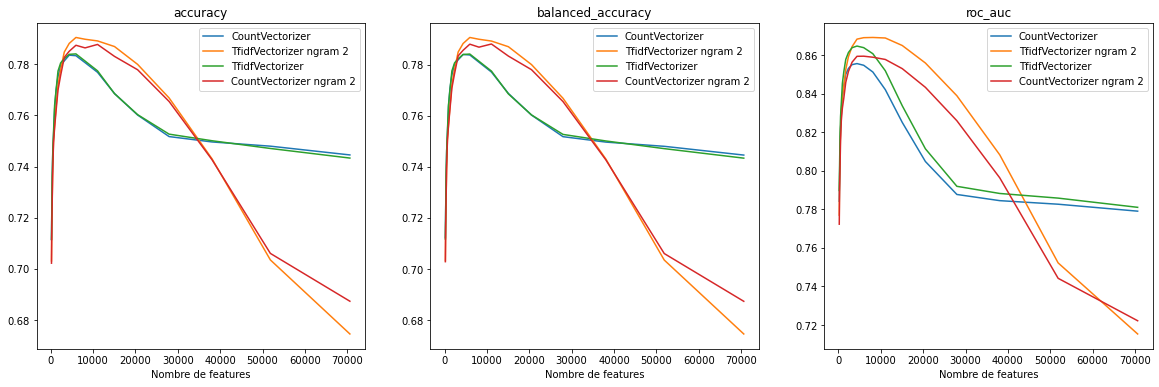

stop_words: True, lemmatization: False, negation: False


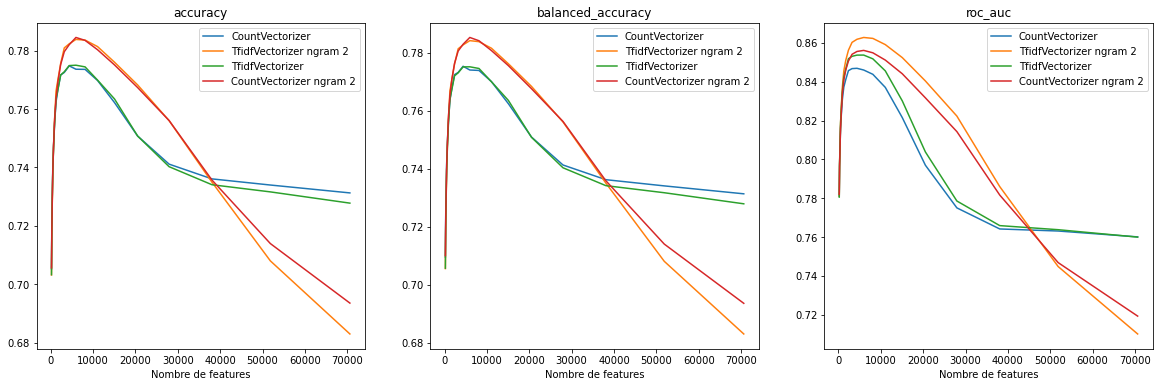

stop_words: True, lemmatization: False, negation: True


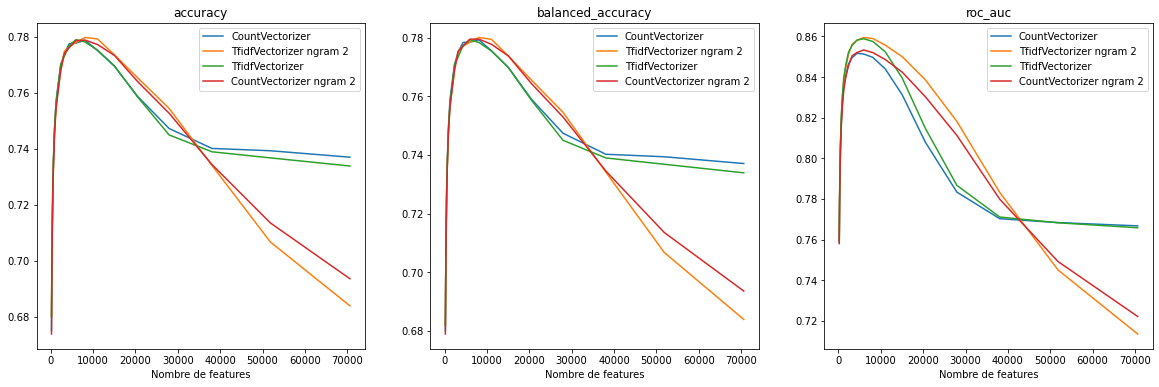

stop_words: True, lemmatization: True, negation: False


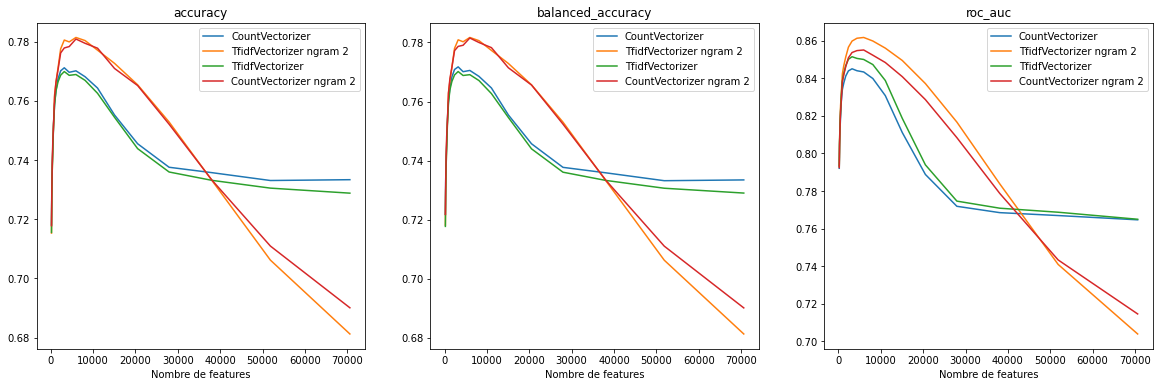

stop_words: True, lemmatization: True, negation: True


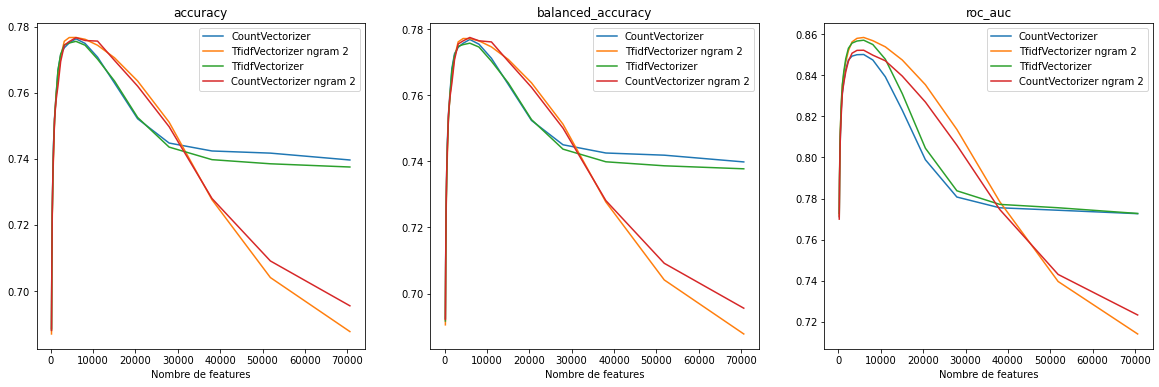

Wall time: 1h 49min 57s


In [32]:
%%time
tables = []
for stop_words in [False, True]:
    for lemmatization in [False, True]:
        for negation in [False, True]:
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
            X = df_temp.text.to_list()
            y = df_temp.sentiment.to_list()
            df_metrics = influence_features(X, y, max_features_list)
            df_metrics['stop_words'] = stop_words
            df_metrics['lemmatization'] = lemmatization
            df_metrics['negation'] = negation
            tables.append(df_metrics)
df_metrics = pd.concat(tables)

In [33]:
df_metrics

,accuracy,balanced_accuracy,roc_auc,features,method,stop_words,lemmatization,negation
0,0.712200,0.713169,0.783515,199,CountVectorizer,False,False,False
1,0.712475,0.712644,0.788261,199,TfidfVectorizer,False,False,False
2,0.710875,0.712220,0.782055,199,CountVectorizer ngram 2,False,False,False
3,0.712275,0.712511,0.787017,199,TfidfVectorizer ngram 2,False,False,False
4,0.728050,0.729086,0.799570,271,CountVectorizer,False,False,False
...,...,...,...,...,...,...,...,...
75,0.704075,0.704124,0.739552,51848,TfidfVectorizer ngram 2,True,True,True
76,0.739650,0.739856,0.772621,70613,CountVectorizer,True,True,True
77,0.737525,0.737771,0.772713,70613,TfidfVectorizer,True,True,True
78,0.695525,0.695560,0.723234,70613,CountVectorizer ngram 2,True,True,True


In [34]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,features,method,stop_words,lemmatization,negation
47,0.793550,0.793632,0.872852,5965,TfidfVectorizer ngram 2,False,False,False
51,0.792075,0.792151,0.872418,8125,TfidfVectorizer ngram 2,False,False,False
55,0.792350,0.792412,0.871660,11065,TfidfVectorizer ngram 2,False,False,False
43,0.791400,0.791526,0.871321,4380,TfidfVectorizer ngram 2,False,False,False
51,0.792825,0.792933,0.871021,8125,TfidfVectorizer ngram 2,False,True,False
...,...,...,...,...,...,...,...,...
79,0.687725,0.687756,0.713975,70613,TfidfVectorizer ngram 2,True,True,True
79,0.683850,0.683895,0.713490,70613,TfidfVectorizer ngram 2,True,False,True
79,0.672325,0.672327,0.711669,70613,TfidfVectorizer ngram 2,False,True,False
79,0.682950,0.682969,0.710074,70613,TfidfVectorizer ngram 2,True,False,False


In [35]:
for elem in ['features', 'method', 'stop_words', 'lemmatization', 'negation']:
    display(df_metrics.groupby(elem).mean().sort_values(by="roc_auc", ascending=False))

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
features,,,,,,
5965,0.781841,0.782223,0.858194,0.5,0.5,0.5
4380,0.780805,0.781250,0.858037,0.5,0.5,0.5
3216,0.779088,0.779620,0.856505,0.5,0.5,0.5
8125,0.780943,0.781260,0.856415,0.5,0.5,0.5
2361,0.775175,0.775801,0.853163,0.5,0.5,0.5
11065,0.778345,0.778597,0.851457,0.5,0.5,0.5
1734,0.769823,0.770552,0.848080,0.5,0.5,0.5
1273,0.763877,0.764696,0.842292,0.5,0.5,0.5
15070,0.772502,0.772712,0.840512,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization,negation
method,,,,,,,
TfidfVectorizer ngram 2,0.752830,0.753275,0.826812,13258.05,0.5,0.5,0.5
TfidfVectorizer,0.753946,0.754334,0.823239,13258.05,0.5,0.5,0.5
CountVectorizer ngram 2,0.752572,0.753519,0.821004,13258.05,0.5,0.5,0.5
CountVectorizer,0.754223,0.755053,0.817776,13258.05,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,lemmatization,negation
stop_words,,,,,,
False,0.757490,0.757798,0.826136,13258.05,0.5,0.5
True,0.749295,0.750292,0.818279,13258.05,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,negation
lemmatization,,,,,,
True,0.753976,0.754622,0.822638,13258.05,0.5,0.5
False,0.752810,0.753469,0.821777,13258.05,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization
negation,,,,,,
False,0.755135,0.755728,0.823108,13258.05,0.5,0.5
True,0.751651,0.752362,0.821307,13258.05,0.5,0.5


In [36]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,features,method,stop_words,lemmatization,negation
47,0.793550,0.793632,0.872852,5965,TfidfVectorizer ngram 2,False,False,False
51,0.792825,0.792933,0.871021,8125,TfidfVectorizer ngram 2,False,True,False
55,0.792350,0.792412,0.871660,11065,TfidfVectorizer ngram 2,False,False,False
51,0.792075,0.792151,0.872418,8125,TfidfVectorizer ngram 2,False,False,False
47,0.791450,0.791582,0.870952,5965,TfidfVectorizer ngram 2,False,False,True
...,...,...,...,...,...,...,...,...
79,0.681200,0.681232,0.703858,70613,TfidfVectorizer ngram 2,True,True,False
0,0.675025,0.680091,0.758383,199,CountVectorizer,True,False,True
2,0.673800,0.678934,0.758013,199,CountVectorizer ngram 2,True,False,True
79,0.674550,0.674560,0.715317,70613,TfidfVectorizer ngram 2,False,True,True


In [37]:
for elem in ['features', 'method', 'stop_words', 'lemmatization', 'negation']:
    display(df_metrics.groupby(elem).mean().sort_values(by="balanced_accuracy", ascending=False))

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
features,,,,,,
5965,0.781841,0.782223,0.858194,0.5,0.5,0.5
8125,0.780943,0.781260,0.856415,0.5,0.5,0.5
4380,0.780805,0.781250,0.858037,0.5,0.5,0.5
3216,0.779088,0.779620,0.856505,0.5,0.5,0.5
11065,0.778345,0.778597,0.851457,0.5,0.5,0.5
2361,0.775175,0.775801,0.853163,0.5,0.5,0.5
15070,0.772502,0.772712,0.840512,0.5,0.5,0.5
1734,0.769823,0.770552,0.848080,0.5,0.5,0.5
1273,0.763877,0.764696,0.842292,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization,negation
method,,,,,,,
CountVectorizer,0.754223,0.755053,0.817776,13258.05,0.5,0.5,0.5
TfidfVectorizer,0.753946,0.754334,0.823239,13258.05,0.5,0.5,0.5
CountVectorizer ngram 2,0.752572,0.753519,0.821004,13258.05,0.5,0.5,0.5
TfidfVectorizer ngram 2,0.752830,0.753275,0.826812,13258.05,0.5,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,lemmatization,negation
stop_words,,,,,,
False,0.757490,0.757798,0.826136,13258.05,0.5,0.5
True,0.749295,0.750292,0.818279,13258.05,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,negation
lemmatization,,,,,,
True,0.753976,0.754622,0.822638,13258.05,0.5,0.5
False,0.752810,0.753469,0.821777,13258.05,0.5,0.5


,accuracy,balanced_accuracy,roc_auc,features,stop_words,lemmatization
negation,,,,,,
False,0.755135,0.755728,0.823108,13258.05,0.5,0.5
True,0.751651,0.752362,0.821307,13258.05,0.5,0.5


In [38]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 02:25:11
